# Lab 5: Species Distribution Modeling with Bagging 

Author: Eva Newby

Climate change and deforestation are accelerating ecosystem degradation, pushing animal species toward the brink of extinction. Understanding the distribution of animals and the factors that influence their ability to thrive in different environments is critical for conservation efforts. By studying these relationships, biological conservationists can develop informed strategies to protect endangered species and maintain biodiversity across diverse ecosystems.

Species are defined by their behavioral, physiological, and ecological attributes, which shape their roles in ecosystems. In turn, ecosystems and their functions are deeply influenced by the species that inhabit them. This reciprocal relationship makes evaluating species' functional diversity and distributions essential for research in biogeography, community ecology, macroevolution, and conservation. Functional diversity is determined by traits such as diet, foraging strata, trophic level, activity cycle, litter size, generation length, habitat breadth, and body mass. These traits influence an animal’s ability to survive and adapt to different climates, playing a crucial role in ecosystem stability.

In this lab, we will explore the connections between animal behaviors, functional traits, and species distributions across different climates.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier

### Step 1: Standardizing column names

The dataset contains several columns that describe different aspects of bird diets. These column names currently include spaces, colons (:), and special characters, which can make them difficult to work with in code.

Load the dataset (BirdTraitData.csv) into a Pandas DataFrame.

The 7 column names that start with "Diet:" should be renamed to simpler version starting with `Diet_` in a way that conforms with this list of key variables:

`AdultBodyMass`, `DietBreadth`, `Diet_Invertebrates`, `Diet_Vertebrates`,`Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`, `TrophicLevel`,`ActivityCycle`, `ForagingStratum`, `MigratoryStatus`,`IncubationTime`, `ClutchSize`, `EggLength`, `EggWidth`,`EggMass`, `NestingHabit`,`MaxLongevity`, `Subarid`

Then select only that list of 21 key variables. **Print the head of your dataframe.** 

In [2]:
# read-in data
fp = '/Users/ejnewby/MEDS/eds232-ml/EDS232-labs/Week5/BirdTraitData.csv'
birds = pd.read_csv(fp, encoding = 'unicode_escape')

# Check columns with 'diet'
diet_columns = [col for col in birds.columns if col.startswith("Diet")]
print(diet_columns)

# Rename columns
birds.rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; offal; carcasses': 'Diet_Other',
}, inplace=True)

# Check column names
print(birds.columns)

# List of key variables
key_variables = [
    'AdultBodyMass', 'DietBreadth', 'Diet_Invertebrates', 'Diet_Vertebrates','Diet_Fruits', 'Diet_Flowers',
    'Diet_Seeds', 'Diet_Plants', 'Diet_Other', 'TrophicLevel','ActivityCycle', 'ForagingStratum', 'MigratoryStatus',
    'IncubationTime', 'ClutchSize', 'EggLength', 'EggWidth','EggMass', 'NestingHabit','MaxLongevity', 'Subarid']

# Select only the key variables
birds = birds[key_variables]

# Print the head of the dataframe
print(birds.head())

['DietBreadth', 'Diet: invertebrates', 'Diet: vertebrates', 'Diet: fruits', 'Diet: flower/nectar/pollen/gums', 'Diet: seeds', 'Diet: other plant materials', 'Diet: scavenge; garbage; carrion; offal; carcasses']
Index(['Order', 'Family', 'Genus', 'Species', 'Authority', 'CommonName',
       'AdultBodyMass', 'DietBreadth', 'Diet_Invertebrates',
       'Diet_Vertebrates', 'Diet_Fruits', 'Diet_Flowers', 'Diet_Seeds',
       'Diet_Plants', 'Diet_Other', 'TrophicLevel', 'ActivityCycle',
       'ForagingStratum', 'MigratoryStatus', 'IncubationTime', 'ClutchSize',
       'EggLength', 'EggWidth', 'EggMass', 'NestingHabit', 'MaxLongevity',
       'Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid', 'Alaotra.Mangoro',
       'Amoron.i.Mania', 'Analamanga', 'Analanjirofo', 'Androy', 'Anosy',
       'Atsimo.Andrefana', 'Atsimo.Atsinanana', 'Atsinanana', 'Betsiboka',
       'Boeny', 'Bongolava', 'DIANA', 'Haute.Matsiatra', 'Ihorombe', 'Itasy',
       'Melaky', 'Menabe', 'SAVA', 'Sofia', 'Vakinankaratra

### Step 2: Encode categorical variables
In our dataset, some columns contain categorical (non-numeric) data, such as species names or habitat types that need to be converted to numerical representations. Let's use label encoding to assign a unique number to each category in a column.

Encode the data using this process:
1. Find all categorical columns in df using `.select_dtypes(include=['object'])`
2. Loop through each categorical column and apply `LabelEncoder()`
3. Replace the original categorical columns with their encoded values.
4. Print the head of your dataframe to ensure that labels were in fact encoded. 

In [3]:
# Find all categorical columns
cat_col = birds.select_dtypes(include=['object']).columns

# Apply LabelEncoder to each categorical column
label_encoders = {}  # store encoder
for col in cat_col:
    le = LabelEncoder()
    birds[col] = le.fit_transform(birds[col]) 
    label_encoders[col] = le  # Save encoder for potential inverse transform

# Print the head
print(birds.head())

   AdultBodyMass  DietBreadth  Diet_Invertebrates  Diet_Vertebrates  \
0          138.5            2                   2                 2   
1         1050.0            1                   1                 2   
2          181.0            2                   2                 2   
3          292.0            2                   2                 2   
4          511.0            2                   2                 2   

   Diet_Fruits  Diet_Flowers  Diet_Seeds  Diet_Plants  Diet_Other  \
0            1             1           1            1           1   
1            1             1           1            1           1   
2            1             1           1            1           1   
3            1             1           1            1           1   
4            1             1           1            1           1   

   TrophicLevel  ...  ForagingStratum  MigratoryStatus  IncubationTime  \
0             3  ...                3                0            31.0   
1         

### Step 3: Defining features, splitting data, and training a bagging classifier
Our goal for this analysis is to predict whether a given bird species is present in Subarid climate zones. 

1. Drop the corresponding variable from the features (X) and define it as the target (y). Then perform the train-test split with 70/30 train/test and a random state of 808.

2. Initialize a bagging classifier with 100 trees, `oob_score =True`, `bootstrap = True` and `random_state = 808`.  

3. Train the model.

In [4]:
# Define X and Y
X = birds.drop(columns=['Subarid'])  # Drop the target variable from features
y = birds['Subarid'] # target variable

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=808)

# Initialize Bagging Classifier
bag_clf = BaggingClassifier(n_estimators=100, 
                            oob_score=True,
                            bootstrap=True,
                            random_state=808)

# Train model
bag_clf.fit(X_train, y_train)

BaggingClassifier(n_estimators=100, oob_score=True, random_state=808)

### Step 4: Make predictions and evaluate the model

1. Generate predictions
- Use the trained bagging model to predict values for the test set (`X_test`).

2. Calculate the Out-of-Bag (OOB) Score
- The OOB score is an internal validation score computed using samples not included in bootstrapped subsets.

3. Compute model accuracy
- Print the OOB score and the bagging accuracy score.

In [5]:
# Generate predictions
y_pred = bag_clf.predict(X_test)

# Print the Out-of-Bag (OOB) Score
print(f"OOB Score: {bag_clf.oob_score_:.3f}")

# assess model accuracy on test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Bagging Classifier Accuracy: {accuracy:.3f}")

OOB Score: 0.882
Bagging Classifier Accuracy: 0.945


### Step 5: Calculate and plot ROC curve

- Use `label=f"Bagging (AUC = {roc_auc_bagging:.2f})"` to include the AUC value in the plot.

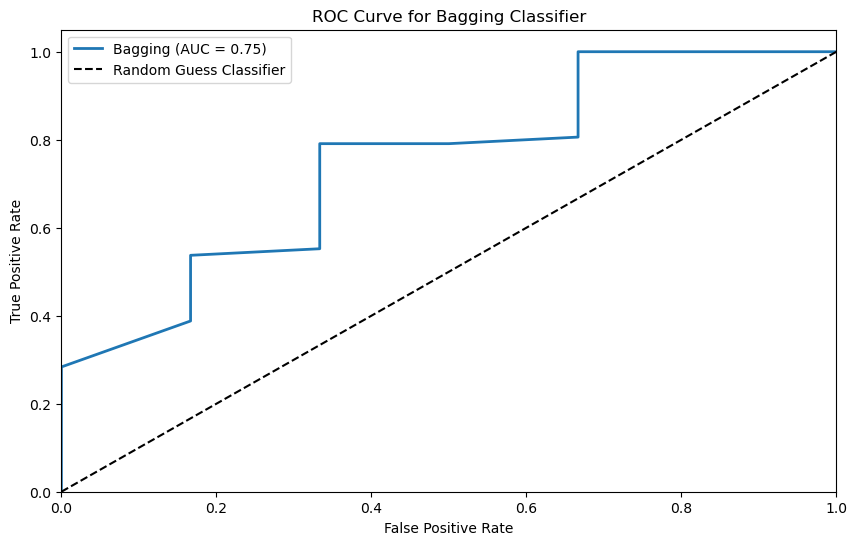

In [6]:
# Get the predicted probabilities for the positive class
y_pred_prob = bag_clf.predict_proba(X_test)[:, 1] 

# Step 2: Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_bagging = auc(fpr, tpr)

# Step 3: Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"Bagging (AUC = {roc_auc_bagging:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess Classifier") 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Bagging Classifier")
plt.legend(loc="upper left")
plt.show()

Now how does the ROC curve look? How does this compare to our classification accuracy metric?  What might be going on? 

The ROC curve shows that our model is not performing very well. The sharp increases indicates imbalance in our dataset. Our classification accuracy metric is...

This compares to our classification accuracy metric... This also indicates that there is class imbalance. 


### Step 6: Introducing upsampling

The ROC curve indicates that our model is not performing well.  This is a common issue in imbalanced datasets, where one class significantly outnumbers the other. To improve our model’s ability to correctly classify both groups, we will upsample the minority class so that both classes have equal representation in the training set.

**Perform upsampling to balance the dataset**
1. Separate the majority and minority classes:
- Identify which class (0,1) is underrepresented (the minority class) and which is overrepresented (the majority class). 
- Separate both the `X_train` data and `y_train` data into all majority class and all minority class sets. 
2. Apply upsampling:
- Use `resample()` to create additional synthetic samples of the minority class *with replacement* until it is the same size as the majority class data. Use a random state of 808. 
3. Combine the balanced classes:
Merge the original majority class with the newly upsampled minority class.
4. Shuffle the resampled dataset:
- Randomly shuffle the data to ensure the model does not learn any unintended patterns from the order of the data. Use a random state of 808 for shuffling both the resampled X and y training data. 
5. Print the value counts for the resampled y training data to ensure that the data is balanced. 


In [7]:
# Separate majority and minority classes.
birds_train = pd.concat([X_train, y_train], axis=1)
majority_class = birds_train[birds_train.Subarid == 1]
minority_class = birds_train[birds_train.Subarid == 0] 

# Upsample the minority class
minority_up = resample(minority_class, 
                              replace=True,    
                              n_samples=len(majority_class), 
                              random_state=808) 

# Combine majority class with upsampled minority class
birds_up = pd.concat([majority_class, minority_up])

# Shuffle the dataset
birds_up = birds_up.sample(frac=1, random_state=808).reset_index(drop=True)

# Separate features and target variable
X_train_balanced = birds_up.drop('Subarid', axis=1)
y_train_balanced = birds_up['Subarid']

# Print value counts 
print(y_train_balanced.value_counts())

Subarid
0    150
1    150
Name: count, dtype: int64


### Step 7: Retrain and evaluate model using balanced data

Now that we have addressed the class imbalance by upsampling the minority class, we will retrain the bagging classifier on the newly balanced dataset and evaluate its performance. This will help us determine whether handling class imbalance improves model accuracy and its ability to distinguish between classes. Create a bagging model using your balanced data. Use a random state of 808. Print the accuracy and and ROC Curve for this new model with balanced data. 

Model Accuracy: 0.877


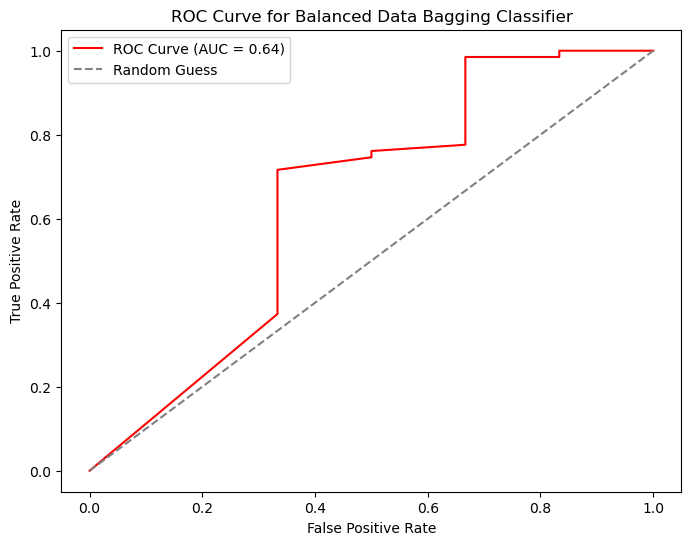

In [8]:
# Bagging Classifier
bagging_clf = BaggingClassifier(random_state=808,
                                n_estimators=100, 
                                oob_score=True,  
                                bootstrap=True)

# Train model
bagging_clf.fit(X_train_balanced, y_train_balanced)

# Predict probabilities
y_pred = bagging_clf.predict(X_test)
y_prob = bagging_clf.predict_proba(X_test)[:, 1] 

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.3f}")

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='red', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Balanced Data Bagging Classifier")
plt.legend()
plt.show()

How did this second model, trained on balanced data, do in comparison to the first on the accuracy and AUC metrics.  How should we interpret those results?  Did the upscaling prove useful?

It appears that this model did not perform better with the balancing

### Step 8: Analyzing feature importance with permutation importance

Understanding which bird traits contribute the most to our model’s predictions is crucial for interpreting results. We covered in lecture how the results of ensemble methods are harder to interpret than a single decision tree.  But we do have some tools to do it.  In this step, we will compute permutation importance, which measures the impact of each trait by shuffling its values and observing the effect on model performance. This will help us identify which functional traits—such as diet, body mass, or habitat breadth—play the biggest role in predicting whether a species is found in a subarid environment.

Use `permutation_importance()` to calculate the importance values.  You'll need to pass it the model, the feature and target test data, and an n_repeats value of 10.

In [9]:
# Permutation importance
perm_imp = permutation_importance(bagging_clf, # trained model
                                 X_test,
                                 y_test,
                                 n_repeats = 10,
                                 random_state=808)


# Store and view importance score
importance_score = perm_imp.importances_mean
feature_names = X_test.columns

# Create df to hold feature importances
importances_df = pd.DataFrame({'feature': feature_names, 'importance': importance_score})

# Sort by importance
importances_df = importances_df.sort_values(by='importance', ascending=False)

# view
importances_df

,feature,importance
18,NestingHabit,0.047945
5,Diet_Flowers,0.010959
4,Diet_Fruits,0.008219
12,MigratoryStatus,0.002740
14,ClutchSize,0.002740
11,ForagingStratum,0.000000
19,MaxLongevity,0.000000
2,Diet_Invertebrates,0.000000
9,TrophicLevel,0.000000
8,Diet_Other,0.000000


What features are most important in our model of species distribution?

The features that are the most positive are the most important in the model of species distribution. So in this case, Nesting Habitat would be the strongest feature, followed by diet_flowers and then diet_fruits. 